# Step 1: Load and Inspect Data

In [1]:
import pandas as pd

# Load datasets
employee_survey = pd.read_csv('Employee_office_survey.csv')
hr_data = pd.read_csv('HR Employee data.csv')
job_position = pd.read_csv('Job_position_structure.csv')
office_codes = pd.read_csv('Office_codes.csv')

# Fix column name mismatch in HR data
hr_data = hr_data.rename(columns={'JobLevel_updated': 'JobLevel'})

In [2]:
employee_survey.isnull().sum()

emp_id        0
off_cde       0
rated_year    0
rating        0
dtype: int64

In [3]:
hr_data.isnull().sum()

EmployeeID                      0
JoiningYear                     0
Age                             0
BusinessTravel                  0
DailyRate                       0
Department                      0
DistanceFromHome                0
EducationField                  0
EmployeeCount                   0
EmployeeNumber                  0
EnvironmentSatisfaction         0
Gender                          0
HourlyRate                      0
JobInvolvement                  0
JobSatisfaction                 0
MaritalStatus                   0
MonthlyIncome                   0
MonthlyRate                     0
NumCompaniesWorked              0
Over18                          0
OverTime                        0
PercentSalaryHike               0
PerformanceRating               0
RelationshipSatisfaction        0
StandardHours                   0
StockOptionLevel                0
TotalWorkingYears               0
TrainingTimesLastYear           0
WorkLifeBalance                 0
YearsAtCompany

In [4]:
hr_data.shape

(13423, 39)

In [5]:
hr_data['LeavingYear'].fillna(2019,inplace=True)

In [6]:
hr_data['Reason'].fillna("unhappy",inplace=True)

In [7]:
hr_data['RelievingStatus'].fillna("Voluntary",inplace=True)

In [8]:
job_position.isnull().sum()

Department    0
JobLevel      0
JobRole       0
dtype: int64

In [9]:
office_codes.isnull().sum()

office_code    0
city           0
province       0
country        0
dtype: int64

# Step 2: Merge Datasets

In [10]:
# Merge HR data with latest survey ratings
employee_survey_sorted = employee_survey.sort_values('rated_year', ascending=False)
latest_survey = employee_survey_sorted.drop_duplicates('emp_id', keep='first')
merged_data = pd.merge(hr_data, latest_survey, left_on='EmployeeID', right_on='emp_id', how='left')

# Merge with office codes and job positions
merged_data = pd.merge(merged_data, office_codes, on='office_code', how='left')
merged_data = pd.merge(merged_data, job_position, on=['Department', 'JobLevel'], how='left')

# Step 3: Feature Engineering

In [11]:
# Add new features
merged_data['PromotionDelay'] = merged_data['YearsSinceLastPromotion'] / (merged_data['YearsAtCompany'] + 1e-6)
merged_data['WorkloadScore'] = merged_data['JobInvolvement'] * (5 - merged_data['WorkLifeBalance'])
merged_data['is_metro_city'] = merged_data['city'].isin(['New York', 'San Francisco', 'London']).astype(int)

# Drop unnecessary columns
merged_data.drop(['emp_id', 'rated_year', 'city', 'office_code'], axis=1, inplace=True)

# Step 4: Handle Missing Data and Outliers

In [12]:
# Impute missing values
merged_data['rating'].fillna(merged_data['rating'].median(), inplace=True)

# Drop columns with no variance
merged_data.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis=1, inplace=True)

# Step 5: EDA

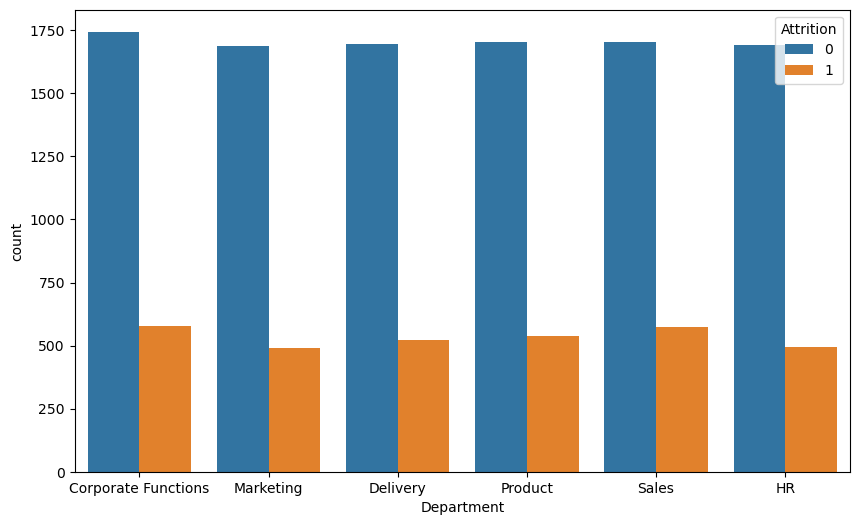

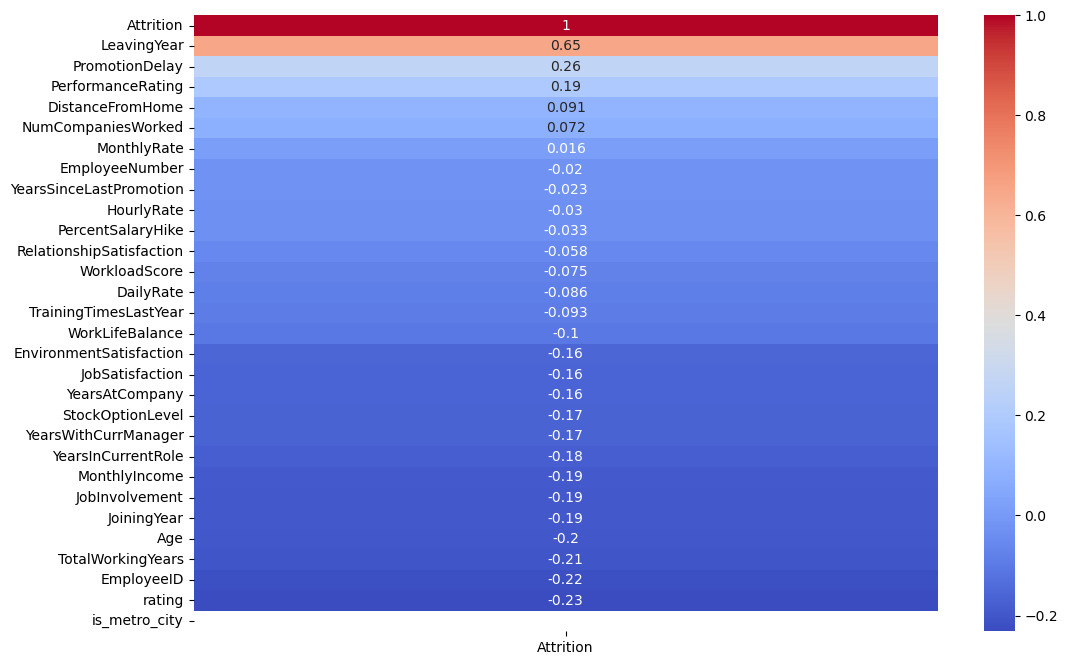

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Attrition to numeric
merged_data['Attrition'] = merged_data['Attrition'].map({'Yes': 1, 'No': 0})

# Plot attrition by department
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_data, x='Department', hue='Attrition')
plt.show()

# Correlation matrix (numeric columns only)
numeric_data = merged_data.select_dtypes(include=['number'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr()[['Attrition']].sort_values('Attrition', ascending=False), 
            annot=True, cmap='coolwarm')
plt.show()

# Step 6: Preprocessing

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Identify ALL categorical columns (including missed ones)
cat_cols = [
    'BusinessTravel', 'Department', 'EducationField', 'Gender',
    'MaritalStatus', 'JobRole', 'RelievingStatus', 'province', 
    'country', 'OverTime', 'Reason'  # Added OverTime and Reason
]

# One-hot encode ALL categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(merged_data[cat_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_cols))

# Drop original categorical columns and combine with encoded features
X = pd.concat([
    merged_data.drop(columns=cat_cols + ['Attrition', 'EmployeeID', 'EmployeeNumber','JobLevel','off_cde']),
    encoded_df
], axis=1)
# Define the target variable (y) as 'Attrition'
y = merged_data['Attrition']

# Ensure all features are numeric (verify)
print("Non-numeric columns remaining:", X.select_dtypes(include='object').columns.tolist())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Non-numeric columns remaining: []


# Step 7: Address Class Imbalance

In [15]:
from imblearn.over_sampling import SMOTE

# Ensure X_train is fully numeric (no strings)
assert X_train.select_dtypes(include='object').empty, "Non-numeric columns still exist!"

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Step 8-9: Build and Evaluate Model

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize and train model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)

# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance.head(10))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2045
           1       1.00      1.00      1.00       640

    accuracy                           1.00      2685
   macro avg       1.00      1.00      1.00      2685
weighted avg       1.00      1.00      1.00      2685

ROC-AUC: 1.0
                      Feature  Importance
92             Reason_unhappy    0.273509
22                LeavingYear    0.224986
78               OverTime_Yes    0.086105
12          PerformanceRating    0.062243
71  RelievingStatus_Voluntary    0.051276
0                 JoiningYear    0.039572
18             YearsAtCompany    0.019457
39       MaritalStatus_Single    0.017368
83          Reason_long hours    0.016628
90            Reason_retiring    0.015751
